# Train RetinaNet (Backbone = ResNet101)

In [1]:
import tensorflow as tf
import numpy as np
from keras_retinanet import models
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.utils.transform import random_transform_generator
from keras_retinanet.utils.image import random_visual_effect_generator
from train_retinanet import create_models, create_callbacks, plot_history

In [2]:
import keras_retinanet
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from keras_retinanet import models, losses
from keras_retinanet.models.retinanet import retinanet_bbox
from keras_retinanet.utils.model import freeze as freeze_model
from keras_retinanet.utils.config import read_config_file, parse_anchor_parameters, parse_pyramid_levels
from keras_retinanet.callbacks.eval import Evaluate
from keras_retinanet.callbacks import RedirectModel
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import SGD
from keras_retinanet.losses import smooth_l1, focal

In [3]:
def model_with_weights(model, weights, skip_mismatch):
    if weights is not None:
        model.load_weights(weights, by_name=True, skip_mismatch=skip_mismatch)
    return model

In [4]:
def create_models(backbone_retinanet, num_classes, weights,
                  freeze_backbone=False, lr=1e-5, config=None):
    modifier = freeze_model if freeze_backbone else None

    # load anchor parameters, or pass None (so that defaults will be used)
    anchor_params = None
    num_anchors   = None
    pyramid_levels = None
    if config and 'anchor_parameters' in config:
        anchor_params = parse_anchor_parameters(config)
        num_anchors   = anchor_params.num_anchors()
    if config and 'pyramid_levels' in config:
        pyramid_levels = parse_pyramid_levels(config)
    
    training_model = model_with_weights(backbone_retinanet(num_classes, num_anchors=num_anchors, modifier=modifier, pyramid_levels=pyramid_levels), weights=weights, skip_mismatch=True)

    # make prediction model
    prediction_model = retinanet_bbox(model=training_model, anchor_params=anchor_params, pyramid_levels=pyramid_levels)

    # compile model
    training_model.compile(
        loss={
            'regression'    : losses.smooth_l1(),
            'classification': losses.focal()
        },
        optimizer=SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True),
      
    )
    return training_model, prediction_model

In [5]:
def create_callbacks(training_model, prediction_model, validation_generator, model_path, log_file):
    callbacks = []
    tensorboard_callback = None
    evaluation = Evaluate(validation_generator, tensorboard=tensorboard_callback, weighted_average=True)
    evaluation = RedirectModel(evaluation, prediction_model)
    callbacks.append(evaluation)
    checkpoint = keras.callbacks.ModelCheckpoint(model_path,
                                                verbose=1,
                                                save_best_only=True,
                                                monitor='mAP',
                                                mode='max'
                                                )
    checkpoint = RedirectModel(checkpoint, training_model)
    callbacks.append(checkpoint)
    callbacks.append(keras.callbacks.CSVLogger(log_file))
    callbacks.append(keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0
    ))
    return callbacks

In [6]:
def plot_history(history, fig, subtitle, epochs):
    epoch_list = list(range(1, epochs+1))
    regression_loss = history.history['loss']
    classification_loss = history.history['classification_loss']
    val_regression_loss = history.history['val_regression_loss']
    val_classification_loss = history.history['val_classification_loss']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_mAP = history.history['mAP']
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13, 20))
    f.subplots_adjust(hspace=0.3)
    t = f.suptitle(subtitle, fontsize=17)

   
    ax1.plot(epoch_list, classification_loss, label='Train Classification Loss')
    ax1.plot(epoch_list, val_classification_loss, label='Validation Classification Loss')
    ax1.set_xticks(np.arange(1, epochs + 1, 1))
    ax1.set_ylim(0, 1.3)
    ax1.set_ylabel('Focal Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Classification Loss')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, regression_loss, label='Train Regression Loss')
    ax2.plot(epoch_list, val_regression_loss, label='Validation Regression Loss')
    ax2.set_xticks(np.arange(1, epochs + 1, 1))
    ax2.set_ylim(0, 3)
    ax2.set_ylabel('Smooth L1 Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Regression Loss')
    l2 = ax2.legend(loc="best")

    ax3.plot(epoch_list, loss, label='Train Loss')
    ax3.plot(epoch_list, val_loss, label='Validation Loss')
    ax3.set_xticks(np.arange(1, epochs + 1, 1))
    ax3.set_ylim(0, 4)
    ax3.set_ylabel('Loss')
    ax3.set_xlabel('Epoch')
    ax3.set_title('Total Loss (Classification Loss + Regression Loss)')
    l3 = ax3.legend(loc="best")
    
    ax4.plot(epoch_list, val_mAP, label='Validation AP')
    ax4.set_xticks(np.arange(1, epochs+1, 1))
    ax4.set_ylim(0,1)
    ax4.set_ylabel('AP')
    ax4.set_xlabel('Epoch')
    ax4.set_title('Average Precision (AP)')
    l4 = ax4.legend(loc="best")
    
    plt.savefig(fig)

In [7]:
np.random.seed(1) 
tf.random.set_seed(1)

In [8]:
tf.test.is_built_with_cuda()  

False

In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #print no of GPU device

Num GPUs Available:  0


In [10]:
backbone = models.backbone('resnet101')
weights = backbone.download_imagenet()

In [11]:
train_generator = CSVGenerator(
    csv_data_file=r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\test.csv',
    csv_class_file=r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\class.csv',
    no_resize = True,
    preprocess_image  = backbone.preprocess_image
)

val_generator = CSVGenerator(
    csv_data_file=r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\valid.csv',
    csv_class_file=r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\class.csv',
    no_resize = True,
    preprocess_image  = backbone.preprocess_image
)

In [12]:
lr = 1e-3 
epochs = 20
steps = 100

## Without Data Augmentation

In [24]:
training_model, prediction_model = create_models(backbone_retinanet=backbone.retinanet,
                                          num_classes=1,
                                          weights=weights,
                                          freeze_backbone=True,
                                          lr=lr
                                          )

C:\Users\Asus\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


C:\Users\Asus\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
log_file = r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Github code\polyp_detection_retinanet-main\result\retinanet_resnet101_log.csv'
model_path = r'C:\Users\Asus\Downloads\ResNet-101-model.keras.h5'
callback = create_callbacks(training_model, prediction_model, val_generator, model_path, log_file)

In [26]:
prediction_model.summary()

Model: "retinanet-bbox"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, None, None,   256         ['conv1[0][0]']                  
                                64)                                                  

                                                                                                  
 res2b (Add)                    (None, None, None,   0           ['bn2b_branch2c[0][0]',          
                                256)                              'res2a_relu[0][0]']             
                                                                                                  
 res2b_relu (Activation)        (None, None, None,   0           ['res2b[0][0]']                  
                                256)                                                              
                                                                                                  
 res2c_branch2a (Conv2D)        (None, None, None,   16384       ['res2b_relu[0][0]']             
                                64)                                                               
                                                                                                  
 bn2c_bran

 tion)                          128)                                                              
                                                                                                  
 res3b1_branch2a_relu (Activati  (None, None, None,   0          ['bn3b1_branch2a[0][0]']         
 on)                            128)                                                              
                                                                                                  
 padding3b1_branch2b (ZeroPaddi  (None, None, None,   0          ['res3b1_branch2a_relu[0][0]']   
 ng2D)                          128)                                                              
                                                                                                  
 res3b1_branch2b (Conv2D)       (None, None, None,   147456      ['padding3b1_branch2b[0][0]']    
                                128)                                                              
          

 res3b3_branch2c (Conv2D)       (None, None, None,   65536       ['res3b3_branch2b_relu[0][0]']   
                                512)                                                              
                                                                                                  
 bn3b3_branch2c (BatchNormaliza  (None, None, None,   2048       ['res3b3_branch2c[0][0]']        
 tion)                          512)                                                              
                                                                                                  
 res3b3 (Add)                   (None, None, None,   0           ['bn3b3_branch2c[0][0]',         
                                512)                              'res3b2_relu[0][0]']            
                                                                                                  
 res3b3_relu (Activation)       (None, None, None,   0           ['res3b3[0][0]']                 
          

                                                                                                  
 res4b2_branch2a (Conv2D)       (None, None, None,   262144      ['res4b1_relu[0][0]']            
                                256)                                                              
                                                                                                  
 bn4b2_branch2a (BatchNormaliza  (None, None, None,   1024       ['res4b2_branch2a[0][0]']        
 tion)                          256)                                                              
                                                                                                  
 res4b2_branch2a_relu (Activati  (None, None, None,   0          ['bn4b2_branch2a[0][0]']         
 on)                            256)                                                              
                                                                                                  
 padding4b

 tion)                          256)                                                              
                                                                                                  
 res4b4_branch2b_relu (Activati  (None, None, None,   0          ['bn4b4_branch2b[0][0]']         
 on)                            256)                                                              
                                                                                                  
 res4b4_branch2c (Conv2D)       (None, None, None,   262144      ['res4b4_branch2b_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 bn4b4_branch2c (BatchNormaliza  (None, None, None,   4096       ['res4b4_branch2c[0][0]']        
 tion)                          1024)                                                             
          

 res4b7_branch2a (Conv2D)       (None, None, None,   262144      ['res4b6_relu[0][0]']            
                                256)                                                              
                                                                                                  
 bn4b7_branch2a (BatchNormaliza  (None, None, None,   1024       ['res4b7_branch2a[0][0]']        
 tion)                          256)                                                              
                                                                                                  
 res4b7_branch2a_relu (Activati  (None, None, None,   0          ['bn4b7_branch2a[0][0]']         
 on)                            256)                                                              
                                                                                                  
 padding4b7_branch2b (ZeroPaddi  (None, None, None,   0          ['res4b7_branch2a_relu[0][0]']   
 ng2D)    

                                                                                                  
 res4b9_branch2b_relu (Activati  (None, None, None,   0          ['bn4b9_branch2b[0][0]']         
 on)                            256)                                                              
                                                                                                  
 res4b9_branch2c (Conv2D)       (None, None, None,   262144      ['res4b9_branch2b_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 bn4b9_branch2c (BatchNormaliza  (None, None, None,   4096       ['res4b9_branch2c[0][0]']        
 tion)                          1024)                                                             
                                                                                                  
 res4b9 (A

                                256)                                                              
                                                                                                  
 bn4b12_branch2a (BatchNormaliz  (None, None, None,   1024       ['res4b12_branch2a[0][0]']       
 ation)                         256)                                                              
                                                                                                  
 res4b12_branch2a_relu (Activat  (None, None, None,   0          ['bn4b12_branch2a[0][0]']        
 ion)                           256)                                                              
                                                                                                  
 padding4b12_branch2b (ZeroPadd  (None, None, None,   0          ['res4b12_branch2a_relu[0][0]']  
 ing2D)                         256)                                                              
          

 res4b14_branch2b_relu (Activat  (None, None, None,   0          ['bn4b14_branch2b[0][0]']        
 ion)                           256)                                                              
                                                                                                  
 res4b14_branch2c (Conv2D)      (None, None, None,   262144      ['res4b14_branch2b_relu[0][0]']  
                                1024)                                                             
                                                                                                  
 bn4b14_branch2c (BatchNormaliz  (None, None, None,   4096       ['res4b14_branch2c[0][0]']       
 ation)                         1024)                                                             
                                                                                                  
 res4b14 (Add)                  (None, None, None,   0           ['bn4b14_branch2c[0][0]',        
          

                                                                                                  
 bn4b17_branch2a (BatchNormaliz  (None, None, None,   1024       ['res4b17_branch2a[0][0]']       
 ation)                         256)                                                              
                                                                                                  
 res4b17_branch2a_relu (Activat  (None, None, None,   0          ['bn4b17_branch2a[0][0]']        
 ion)                           256)                                                              
                                                                                                  
 padding4b17_branch2b (ZeroPadd  (None, None, None,   0          ['res4b17_branch2a_relu[0][0]']  
 ing2D)                         256)                                                              
                                                                                                  
 res4b17_b

 ion)                           256)                                                              
                                                                                                  
 res4b19_branch2c (Conv2D)      (None, None, None,   262144      ['res4b19_branch2b_relu[0][0]']  
                                1024)                                                             
                                                                                                  
 bn4b19_branch2c (BatchNormaliz  (None, None, None,   4096       ['res4b19_branch2c[0][0]']       
 ation)                         1024)                                                             
                                                                                                  
 res4b19 (Add)                  (None, None, None,   0           ['bn4b19_branch2c[0][0]',        
                                1024)                             'res4b18_relu[0][0]']           
          

 bn4b22_branch2a (BatchNormaliz  (None, None, None,   1024       ['res4b22_branch2a[0][0]']       
 ation)                         256)                                                              
                                                                                                  
 res4b22_branch2a_relu (Activat  (None, None, None,   0          ['bn4b22_branch2a[0][0]']        
 ion)                           256)                                                              
                                                                                                  
 padding4b22_branch2b (ZeroPadd  (None, None, None,   0          ['res4b22_branch2a_relu[0][0]']  
 ing2D)                         256)                                                              
                                                                                                  
 res4b22_branch2b (Conv2D)      (None, None, None,   589824      ['padding4b22_branch2b[0][0]']   
          

                                                                                                  
 bn5b_branch2b (BatchNormalizat  (None, None, None,   2048       ['res5b_branch2b[0][0]']         
 ion)                           512)                                                              
                                                                                                  
 res5b_branch2b_relu (Activatio  (None, None, None,   0          ['bn5b_branch2b[0][0]']          
 n)                             512)                                                              
                                                                                                  
 res5b_branch2c (Conv2D)        (None, None, None,   1048576     ['res5b_branch2b_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 bn5b_bran

                                256)                                                              
                                                                                                  
 P5 (Conv2D)                    (None, None, None,   590080      ['C5_reduced[0][0]']             
                                256)                                                              
                                                                                                  
 P7 (Conv2D)                    (None, None, None,   590080      ['C6_relu[0][0]']                
                                256)                                                              
                                                                                                  
 anchors_0 (Anchors)            (None, None, 4)      0           ['P3[0][0]']                     
                                                                                                  
 anchors_1

In [27]:
training_model.summary()

Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, None, None,   256         ['conv1[0][0]']                  
                                64)                                                       

                                                                                                  
 res2b (Add)                    (None, None, None,   0           ['bn2b_branch2c[0][0]',          
                                256)                              'res2a_relu[0][0]']             
                                                                                                  
 res2b_relu (Activation)        (None, None, None,   0           ['res2b[0][0]']                  
                                256)                                                              
                                                                                                  
 res2c_branch2a (Conv2D)        (None, None, None,   16384       ['res2b_relu[0][0]']             
                                64)                                                               
                                                                                                  
 bn2c_bran

 tion)                          128)                                                              
                                                                                                  
 res3b1_branch2a_relu (Activati  (None, None, None,   0          ['bn3b1_branch2a[0][0]']         
 on)                            128)                                                              
                                                                                                  
 padding3b1_branch2b (ZeroPaddi  (None, None, None,   0          ['res3b1_branch2a_relu[0][0]']   
 ng2D)                          128)                                                              
                                                                                                  
 res3b1_branch2b (Conv2D)       (None, None, None,   147456      ['padding3b1_branch2b[0][0]']    
                                128)                                                              
          

 res3b3_branch2c (Conv2D)       (None, None, None,   65536       ['res3b3_branch2b_relu[0][0]']   
                                512)                                                              
                                                                                                  
 bn3b3_branch2c (BatchNormaliza  (None, None, None,   2048       ['res3b3_branch2c[0][0]']        
 tion)                          512)                                                              
                                                                                                  
 res3b3 (Add)                   (None, None, None,   0           ['bn3b3_branch2c[0][0]',         
                                512)                              'res3b2_relu[0][0]']            
                                                                                                  
 res3b3_relu (Activation)       (None, None, None,   0           ['res3b3[0][0]']                 
          

                                                                                                  
 res4b2_branch2a (Conv2D)       (None, None, None,   262144      ['res4b1_relu[0][0]']            
                                256)                                                              
                                                                                                  
 bn4b2_branch2a (BatchNormaliza  (None, None, None,   1024       ['res4b2_branch2a[0][0]']        
 tion)                          256)                                                              
                                                                                                  
 res4b2_branch2a_relu (Activati  (None, None, None,   0          ['bn4b2_branch2a[0][0]']         
 on)                            256)                                                              
                                                                                                  
 padding4b

 tion)                          256)                                                              
                                                                                                  
 res4b4_branch2b_relu (Activati  (None, None, None,   0          ['bn4b4_branch2b[0][0]']         
 on)                            256)                                                              
                                                                                                  
 res4b4_branch2c (Conv2D)       (None, None, None,   262144      ['res4b4_branch2b_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 bn4b4_branch2c (BatchNormaliza  (None, None, None,   4096       ['res4b4_branch2c[0][0]']        
 tion)                          1024)                                                             
          

 res4b7_branch2a (Conv2D)       (None, None, None,   262144      ['res4b6_relu[0][0]']            
                                256)                                                              
                                                                                                  
 bn4b7_branch2a (BatchNormaliza  (None, None, None,   1024       ['res4b7_branch2a[0][0]']        
 tion)                          256)                                                              
                                                                                                  
 res4b7_branch2a_relu (Activati  (None, None, None,   0          ['bn4b7_branch2a[0][0]']         
 on)                            256)                                                              
                                                                                                  
 padding4b7_branch2b (ZeroPaddi  (None, None, None,   0          ['res4b7_branch2a_relu[0][0]']   
 ng2D)    

                                                                                                  
 res4b9_branch2b_relu (Activati  (None, None, None,   0          ['bn4b9_branch2b[0][0]']         
 on)                            256)                                                              
                                                                                                  
 res4b9_branch2c (Conv2D)       (None, None, None,   262144      ['res4b9_branch2b_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 bn4b9_branch2c (BatchNormaliza  (None, None, None,   4096       ['res4b9_branch2c[0][0]']        
 tion)                          1024)                                                             
                                                                                                  
 res4b9 (A

                                256)                                                              
                                                                                                  
 bn4b12_branch2a (BatchNormaliz  (None, None, None,   1024       ['res4b12_branch2a[0][0]']       
 ation)                         256)                                                              
                                                                                                  
 res4b12_branch2a_relu (Activat  (None, None, None,   0          ['bn4b12_branch2a[0][0]']        
 ion)                           256)                                                              
                                                                                                  
 padding4b12_branch2b (ZeroPadd  (None, None, None,   0          ['res4b12_branch2a_relu[0][0]']  
 ing2D)                         256)                                                              
          

 res4b14_branch2b_relu (Activat  (None, None, None,   0          ['bn4b14_branch2b[0][0]']        
 ion)                           256)                                                              
                                                                                                  
 res4b14_branch2c (Conv2D)      (None, None, None,   262144      ['res4b14_branch2b_relu[0][0]']  
                                1024)                                                             
                                                                                                  
 bn4b14_branch2c (BatchNormaliz  (None, None, None,   4096       ['res4b14_branch2c[0][0]']       
 ation)                         1024)                                                             
                                                                                                  
 res4b14 (Add)                  (None, None, None,   0           ['bn4b14_branch2c[0][0]',        
          

                                                                                                  
 bn4b17_branch2a (BatchNormaliz  (None, None, None,   1024       ['res4b17_branch2a[0][0]']       
 ation)                         256)                                                              
                                                                                                  
 res4b17_branch2a_relu (Activat  (None, None, None,   0          ['bn4b17_branch2a[0][0]']        
 ion)                           256)                                                              
                                                                                                  
 padding4b17_branch2b (ZeroPadd  (None, None, None,   0          ['res4b17_branch2a_relu[0][0]']  
 ing2D)                         256)                                                              
                                                                                                  
 res4b17_b

 ion)                           256)                                                              
                                                                                                  
 res4b19_branch2c (Conv2D)      (None, None, None,   262144      ['res4b19_branch2b_relu[0][0]']  
                                1024)                                                             
                                                                                                  
 bn4b19_branch2c (BatchNormaliz  (None, None, None,   4096       ['res4b19_branch2c[0][0]']       
 ation)                         1024)                                                             
                                                                                                  
 res4b19 (Add)                  (None, None, None,   0           ['bn4b19_branch2c[0][0]',        
                                1024)                             'res4b18_relu[0][0]']           
          

 bn4b22_branch2a (BatchNormaliz  (None, None, None,   1024       ['res4b22_branch2a[0][0]']       
 ation)                         256)                                                              
                                                                                                  
 res4b22_branch2a_relu (Activat  (None, None, None,   0          ['bn4b22_branch2a[0][0]']        
 ion)                           256)                                                              
                                                                                                  
 padding4b22_branch2b (ZeroPadd  (None, None, None,   0          ['res4b22_branch2a_relu[0][0]']  
 ing2D)                         256)                                                              
                                                                                                  
 res4b22_branch2b (Conv2D)      (None, None, None,   589824      ['padding4b22_branch2b[0][0]']   
          

                                                                                                  
 bn5b_branch2b (BatchNormalizat  (None, None, None,   2048       ['res5b_branch2b[0][0]']         
 ion)                           512)                                                              
                                                                                                  
 res5b_branch2b_relu (Activatio  (None, None, None,   0          ['bn5b_branch2b[0][0]']          
 n)                             512)                                                              
                                                                                                  
 res5b_branch2c (Conv2D)        (None, None, None,   1048576     ['res5b_branch2b_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 bn5b_bran

                                256)                                                              
                                                                                                  
 P5 (Conv2D)                    (None, None, None,   590080      ['C5_reduced[0][0]']             
                                256)                                                              
                                                                                                  
 P7 (Conv2D)                    (None, None, None,   590080      ['C6_relu[0][0]']                
                                256)                                                              
                                                                                                  
 regression_submodel (Functiona  (None, None, 4)     2443300     ['P3[0][0]',                     
 l)                                                               'P4[0][0]',                     
          

In [28]:
history = training_model.fit(
                x=train_generator,
                epochs=epochs,
                verbose=1,
                validation_data=val_generator,
                callbacks=callback,
                steps_per_epoch = steps
                )

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 3.7391 - regression_loss: 2.6980 - classification_loss: 1.0411

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:08 Time:  0:03:08
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0527
mAP: 0.0527

Epoch 1: mAP improved from -inf to 0.05272, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 910s 9s/step - loss: 3.7391 - regression_loss: 2.6980 - classification_loss: 1.0411 - val_loss: 3.1840 - val_regression_loss: 2.6004 - val_classification_loss: 0.5836 - mAP: 0.0527 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 3.1880 - regression_loss: 2.5539 - classification_loss: 0.6341

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:08 Time:  0:03:08
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.1444
mAP: 0.1444

Epoch 2: mAP improved from 0.05272 to 0.14441, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 710s 7s/step - loss: 3.1880 - regression_loss: 2.5539 - classification_loss: 0.6341 - val_loss: 2.9044 - val_regression_loss: 2.4297 - val_classification_loss: 0.4748 - mAP: 0.1444 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 2.9011 - regression_loss: 2.3070 - classification_loss: 0.5941

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 3: mAP did not improve from 0.14441
100/100 [==============================] - 687s 7s/step - loss: 2.9011 - regression_loss: 2.3070 - classification_loss: 0.5941 - val_loss: 3.4238 - val_regression_loss: 2.3534 - val_classification_loss: 1.0704 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 2.9958 - regression_loss: 2.0966 - classification_loss: 0.8992

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.3701
mAP: 0.3701

Epoch 4: mAP improved from 0.14441 to 0.37015, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 682s 7s/step - loss: 2.9958 - regression_loss: 2.0966 - classification_loss: 0.8992 - val_loss: 2.5043 - val_regression_loss: 2.0200 - val_classification_loss: 0.4843 - mAP: 0.3701 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - ETA: 0s - loss: 2.3154 - regression_loss: 1.8336 - classification_loss: 0.4818

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:24 Time:  0:03:24
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.3017
mAP: 0.3017

Epoch 5: mAP did not improve from 0.37015
100/100 [==============================] - 757s 8s/step - loss: 2.3154 - regression_loss: 1.8336 - classification_loss: 0.4818 - val_loss: 2.5005 - val_regression_loss: 2.0692 - val_classification_loss: 0.4314 - mAP: 0.3017 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - ETA: 0s - loss: 1.9412 - regression_loss: 1.6153 - classification_loss: 0.3258

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:25 Time:  0:03:25
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.5832
mAP: 0.5832

Epoch 6: mAP improved from 0.37015 to 0.58316, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 779s 8s/step - loss: 1.9412 - regression_loss: 1.6153 - classification_loss: 0.3258 - val_loss: 2.1973 - val_regression_loss: 1.8498 - val_classification_loss: 0.3475 - mAP: 0.5832 - lr: 0.0010
Epoch 7/20
100/100 [==============================] - ETA: 0s - loss: 1.7084 - regression_loss: 1.4537 - classification_loss: 0.2547

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.6397
mAP: 0.6397

Epoch 7: mAP improved from 0.58316 to 0.63969, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 721s 7s/step - loss: 1.7084 - regression_loss: 1.4537 - classification_loss: 0.2547 - val_loss: 2.0941 - val_regression_loss: 1.7543 - val_classification_loss: 0.3398 - mAP: 0.6397 - lr: 0.0010
Epoch 8/20
100/100 [==============================] - ETA: 0s - loss: 1.5504 - regression_loss: 1.3054 - classification_loss: 0.2450

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.6383
mAP: 0.6383

Epoch 8: mAP did not improve from 0.63969
100/100 [==============================] - 679s 7s/step - loss: 1.5504 - regression_loss: 1.3054 - classification_loss: 0.2450 - val_loss: 2.1731 - val_regression_loss: 1.8316 - val_classification_loss: 0.3416 - mAP: 0.6383 - lr: 0.0010
Epoch 9/20
100/100 [==============================] - ETA: 0s - loss: 1.4334 - regression_loss: 1.2359 - classification_loss: 0.1975

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:10 Time:  0:03:10
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.6754
mAP: 0.6754

Epoch 9: mAP improved from 0.63969 to 0.67536, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 729s 7s/step - loss: 1.4334 - regression_loss: 1.2359 - classification_loss: 0.1975 - val_loss: 2.0954 - val_regression_loss: 1.7804 - val_classification_loss: 0.3150 - mAP: 0.6754 - lr: 0.0010
Epoch 10/20
100/100 [==============================] - ETA: 0s - loss: 1.2534 - regression_loss: 1.1057 - classification_loss: 0.1477

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:14 Time:  0:03:14
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.7383
mAP: 0.7383

Epoch 10: mAP improved from 0.67536 to 0.73828, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 744s 7s/step - loss: 1.2534 - regression_loss: 1.1057 - classification_loss: 0.1477 - val_loss: 2.0241 - val_regression_loss: 1.6618 - val_classification_loss: 0.3623 - mAP: 0.7383 - lr: 0.0010
Epoch 11/20
100/100 [==============================] - ETA: 0s - loss: 1.1013 - regression_loss: 0.9843 - classification_loss: 0.1170

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.7274
mAP: 0.7274

Epoch 11: mAP did not improve from 0.73828
100/100 [==============================] - 721s 7s/step - loss: 1.1013 - regression_loss: 0.9843 - classification_loss: 0.1170 - val_loss: 1.9997 - val_regression_loss: 1.6797 - val_classification_loss: 0.3200 - mAP: 0.7274 - lr: 0.0010
Epoch 12/20
100/100 [==============================] - ETA: 0s - loss: 1.0391 - regression_loss: 0.9368 - classification_loss: 0.1024

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.7551
mAP: 0.7551

Epoch 12: mAP improved from 0.73828 to 0.75506, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 682s 7s/step - loss: 1.0391 - regression_loss: 0.9368 - classification_loss: 0.1024 - val_loss: 1.9912 - val_regression_loss: 1.6466 - val_classification_loss: 0.3446 - mAP: 0.7551 - lr: 0.0010
Epoch 13/20
100/100 [==============================] - ETA: 0s - loss: 0.9827 - regression_loss: 0.8901 - classification_loss: 0.0926

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.7457
mAP: 0.7457

Epoch 13: mAP did not improve from 0.75506
100/100 [==============================] - 680s 7s/step - loss: 0.9827 - regression_loss: 0.8901 - classification_loss: 0.0926 - val_loss: 1.9085 - val_regression_loss: 1.5762 - val_classification_loss: 0.3323 - mAP: 0.7457 - lr: 0.0010
Epoch 14/20
100/100 [==============================] - ETA: 0s - loss: 0.8536 - regression_loss: 0.7799 - classification_loss: 0.0738

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.7355
mAP: 0.7355

Epoch 14: mAP did not improve from 0.75506
100/100 [==============================] - 679s 7s/step - loss: 0.8536 - regression_loss: 0.7799 - classification_loss: 0.0738 - val_loss: 2.0907 - val_regression_loss: 1.7166 - val_classification_loss: 0.3741 - mAP: 0.7355 - lr: 0.0010
Epoch 15/20
100/100 [==============================] - ETA: 0s - loss: 0.8879 - regression_loss: 0.8233 - classification_loss: 0.0646

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:16 Time:  0:03:16
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.7628
mAP: 0.7628

Epoch 15: mAP improved from 0.75506 to 0.76284, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 715s 7s/step - loss: 0.8879 - regression_loss: 0.8233 - classification_loss: 0.0646 - val_loss: 1.9988 - val_regression_loss: 1.6463 - val_classification_loss: 0.3525 - mAP: 0.7628 - lr: 0.0010
Epoch 16/20
100/100 [==============================] - ETA: 0s - loss: 0.7507 - regression_loss: 0.6889 - classification_loss: 0.0618

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:18 Time:  0:03:18
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.7304
mAP: 0.7304

Epoch 16: mAP did not improve from 0.76284
100/100 [==============================] - 738s 7s/step - loss: 0.7507 - regression_loss: 0.6889 - classification_loss: 0.0618 - val_loss: 1.9384 - val_regression_loss: 1.5852 - val_classification_loss: 0.3532 - mAP: 0.7304 - lr: 0.0010
Epoch 17/20
100/100 [==============================] - ETA: 0s - loss: 0.6928 - regression_loss: 0.6373 - classification_loss: 0.0555

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.7114
mAP: 0.7114

Epoch 17: mAP did not improve from 0.76284
100/100 [==============================] - 715s 7s/step - loss: 0.6928 - regression_loss: 0.6373 - classification_loss: 0.0555 - val_loss: 1.9556 - val_regression_loss: 1.5910 - val_classification_loss: 0.3647 - mAP: 0.7114 - lr: 0.0010
Epoch 18/20
100/100 [==============================] - ETA: 0s - loss: 0.7247 - regression_loss: 0.6767 - classification_loss: 0.0479

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.7305
mAP: 0.7305

Epoch 18: mAP did not improve from 0.76284

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 681s 7s/step - loss: 0.7247 - regression_loss: 0.6767 - classification_loss: 0.0479 - val_loss: 2.1496 - val_regression_loss: 1.7500 - val_classification_loss: 0.3996 - mAP: 0.7305 - lr: 0.0010
Epoch 19/20
100/100 [==============================] - ETA: 0s - loss: 0.6353 - regression_loss: 0.5839 - classification_loss: 0.0514

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.7373
mAP: 0.7373

Epoch 19: mAP did not improve from 0.76284
100/100 [==============================] - 679s 7s/step - loss: 0.6353 - regression_loss: 0.5839 - classification_loss: 0.0514 - val_loss: 1.9515 - val_regression_loss: 1.5767 - val_classification_loss: 0.3748 - mAP: 0.7373 - lr: 1.0000e-04
Epoch 20/20
100/100 [==============================] - ETA: 0s - loss: 0.4622 - regression_loss: 0.4220 - classification_loss: 0.0401

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.7418
mAP: 0.7418

Epoch 20: mAP did not improve from 0.76284
100/100 [==============================] - 686s 7s/step - loss: 0.4622 - regression_loss: 0.4220 - classification_loss: 0.0401 - val_loss: 1.9397 - val_regression_loss: 1.5731 - val_classification_loss: 0.3665 - mAP: 0.7418 - lr: 1.0000e-04


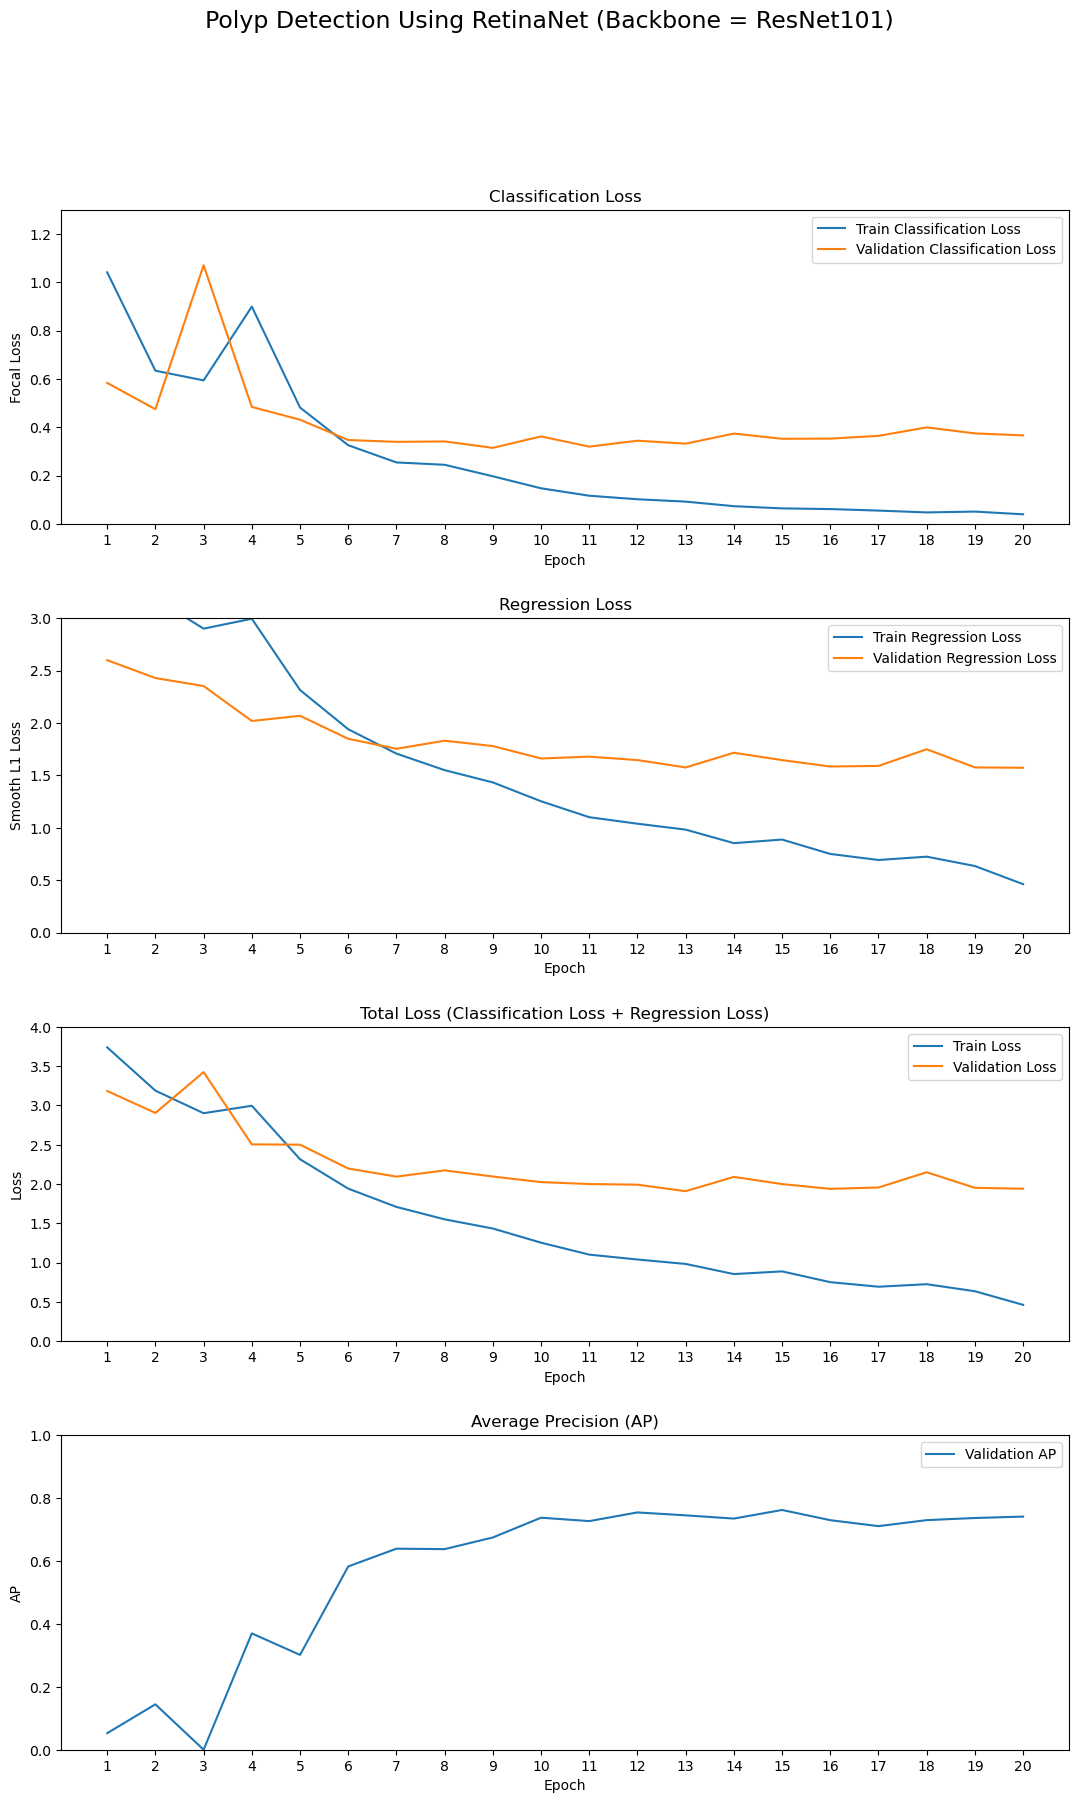

In [29]:
fig = r'C:\Users\Asus\Desktop\retinanet_resnet101.png'
plot_history(history, fig, 'Polyp Detection Using RetinaNet (Backbone = ResNet101)', epochs)

## With Data Augmentation

In [13]:
training_model_aug, prediction_model_aug = create_models(backbone_retinanet=backbone.retinanet,
                                          num_classes=1,
                                          weights=weights,
                                          freeze_backbone=True,
                                          lr=lr)

C:\Users\Asus\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


C:\Users\Asus\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
transform_generator = random_transform_generator(
            min_rotation=-0.1,
            max_rotation=0.1,
            min_scaling=(0.9, 0.9),
            max_scaling=(1.1, 1.1),
            flip_x_chance=0.5,
            flip_y_chance=0.5,
        )
visual_effect_generator = random_visual_effect_generator(
            contrast_range=(0.9, 1.1),
            brightness_range=(-.1, .1),
        )

In [15]:
train_generator_aug = CSVGenerator(
    csv_data_file=r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\train.csv',
    csv_class_file=r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Dataset\Kvasir-SEG\class.csv',
    no_resize = True,
    preprocess_image  = backbone.preprocess_image,
    transform_generator=transform_generator,
    visual_effect_generator=visual_effect_generator
)

In [16]:
model_path_aug = r'C:\Users\Asus\Downloads\ResNet-101-model.keras.h5'
log_file_aug = r'C:\Users\Asus\Desktop\PG Project\Nandhini\Phase 2\Github code\polyp_detection_retinanet-main\result\retinanet_resnet101_aug_log.csv'
callback_aug = create_callbacks(training_model_aug, prediction_model_aug, val_generator, model_path_aug, log_file_aug)

In [17]:
history_aug = training_model_aug.fit(
                x=train_generator_aug,
                epochs=epochs,
                verbose=1,
                validation_data=val_generator,
                callbacks=callback_aug,
                steps_per_epoch = steps
                )

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 3.6811 - regression_loss: 2.6690 - classification_loss: 1.0121

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:12 Time:  0:03:12
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0723
mAP: 0.0723

Epoch 1: mAP improved from -inf to 0.07233, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 740s 7s/step - loss: 3.6811 - regression_loss: 2.6690 - classification_loss: 1.0121 - val_loss: 3.4095 - val_regression_loss: 2.5879 - val_classification_loss: 0.8216 - mAP: 0.0723 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 3.3690 - regression_loss: 2.5954 - classification_loss: 0.7736

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:05 Time:  0:03:05
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0856
mAP: 0.0856

Epoch 2: mAP improved from 0.07233 to 0.08562, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 707s 7s/step - loss: 3.3690 - regression_loss: 2.5954 - classification_loss: 0.7736 - val_loss: 3.1444 - val_regression_loss: 2.4596 - val_classification_loss: 0.6847 - mAP: 0.0856 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 3.4069 - regression_loss: 2.3725 - classification_loss: 1.0344

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:58 Time:  0:02:58
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 3: mAP did not improve from 0.08562
100/100 [==============================] - 687s 7s/step - loss: 3.4069 - regression_loss: 2.3725 - classification_loss: 1.0344 - val_loss: 3.4393 - val_regression_loss: 2.3313 - val_classification_loss: 1.1080 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 3.4383 - regression_loss: 2.3383 - classification_loss: 1.1001

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 4: mAP did not improve from 0.08562
100/100 [==============================] - 684s 7s/step - loss: 3.4383 - regression_loss: 2.3383 - classification_loss: 1.1001 - val_loss: 3.3539 - val_regression_loss: 2.2689 - val_classification_loss: 1.0850 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 5/20
100/100 [==============================] - ETA: 0s - loss: 2.9203 - regression_loss: 2.1241 - classification_loss: 0.7962

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:58 Time:  0:02:58
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.1925
mAP: 0.1925

Epoch 5: mAP improved from 0.08562 to 0.19248, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 688s 7s/step - loss: 2.9203 - regression_loss: 2.1241 - classification_loss: 0.7962 - val_loss: 2.6938 - val_regression_loss: 2.1702 - val_classification_loss: 0.5236 - mAP: 0.1925 - lr: 0.0010
Epoch 6/20
100/100 [==============================] - ETA: 0s - loss: 2.4617 - regression_loss: 1.9657 - classification_loss: 0.4961

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.5154
mAP: 0.5154

Epoch 6: mAP improved from 0.19248 to 0.51540, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5
100/100 [==============================] - 683s 7s/step - loss: 2.4617 - regression_loss: 1.9657 - classification_loss: 0.4961 - val_loss: 2.4492 - val_regression_loss: 1.9442 - val_classification_loss: 0.5050 - mAP: 0.5154 - lr: 0.0010
Epoch 7/20
100/100 [==============================] - ETA: 0s - loss: 2.6113 - regression_loss: 1.9994 - classification_loss: 0.6120

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.4501
mAP: 0.4501

Epoch 7: mAP did not improve from 0.51540
100/100 [==============================] - 684s 7s/step - loss: 2.6113 - regression_loss: 1.9994 - classification_loss: 0.6120 - val_loss: 2.4914 - val_regression_loss: 1.9716 - val_classification_loss: 0.5198 - mAP: 0.4501 - lr: 0.0010
Epoch 8/20
100/100 [==============================] - ETA: 0s - loss: 2.9381 - regression_loss: 1.9017 - classification_loss: 1.0364

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 8: mAP did not improve from 0.51540
100/100 [==============================] - 683s 7s/step - loss: 2.9381 - regression_loss: 1.9017 - classification_loss: 1.0364 - val_loss: 2.8792 - val_regression_loss: 1.8148 - val_classification_loss: 1.0644 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 9/20
100/100 [==============================] - ETA: 0s - loss: 2.6966 - regression_loss: 1.8493 - classification_loss: 0.8472

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.4509
mAP: 0.4509

Epoch 9: mAP did not improve from 0.51540
100/100 [==============================] - 685s 7s/step - loss: 2.6966 - regression_loss: 1.8493 - classification_loss: 0.8472 - val_loss: 2.3570 - val_regression_loss: 1.8567 - val_classification_loss: 0.5002 - mAP: 0.4509 - lr: 0.0010
Epoch 10/20
100/100 [==============================] - ETA: 0s - loss: 2.5218 - regression_loss: 1.7618 - classification_loss: 0.7600

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 10: mAP did not improve from 0.51540
100/100 [==============================] - 683s 7s/step - loss: 2.5218 - regression_loss: 1.7618 - classification_loss: 0.7600 - val_loss: 2.8650 - val_regression_loss: 1.7985 - val_classification_loss: 1.0666 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 11/20
100/100 [==============================] - ETA: 0s - loss: 2.7596 - regression_loss: 1.7008 - classification_loss: 1.0588

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 11: mAP did not improve from 0.51540
100/100 [==============================] - 684s 7s/step - loss: 2.7596 - regression_loss: 1.7008 - classification_loss: 1.0588 - val_loss: 2.7361 - val_regression_loss: 1.6819 - val_classification_loss: 1.0542 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 12/20
100/100 [==============================] - ETA: 0s - loss: 2.7510 - regression_loss: 1.7041 - classification_loss: 1.0469

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:58 Time:  0:02:58
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 12: mAP did not improve from 0.51540
100/100 [==============================] - 684s 7s/step - loss: 2.7510 - regression_loss: 1.7041 - classification_loss: 1.0469 - val_loss: 2.7661 - val_regression_loss: 1.7248 - val_classification_loss: 1.0414 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 13/20
100/100 [==============================] - ETA: 0s - loss: 2.6766 - regression_loss: 1.6430 - classification_loss: 1.0335

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:13 Time:  0:03:13
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 13: mAP did not improve from 0.51540
100/100 [==============================] - 719s 7s/step - loss: 2.6766 - regression_loss: 1.6430 - classification_loss: 1.0335 - val_loss: 2.6093 - val_regression_loss: 1.5871 - val_classification_loss: 1.0223 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 14/20
100/100 [==============================] - ETA: 0s - loss: 2.4884 - regression_loss: 1.6070 - classification_loss: 0.8814

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.4018
mAP: 0.4018

Epoch 14: mAP did not improve from 0.51540
100/100 [==============================] - 713s 7s/step - loss: 2.4884 - regression_loss: 1.6070 - classification_loss: 0.8814 - val_loss: 2.0488 - val_regression_loss: 1.6248 - val_classification_loss: 0.4240 - mAP: 0.4018 - lr: 0.0010
Epoch 15/20
100/100 [==============================] - ETA: 0s - loss: 2.0493 - regression_loss: 1.6043 - classification_loss: 0.4450

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.5089
mAP: 0.5089

Epoch 15: mAP did not improve from 0.51540
100/100 [==============================] - 682s 7s/step - loss: 2.0493 - regression_loss: 1.6043 - classification_loss: 0.4450 - val_loss: 2.8228 - val_regression_loss: 1.6240 - val_classification_loss: 1.1987 - mAP: 0.5089 - lr: 0.0010
Epoch 16/20
100/100 [==============================] - ETA: 0s - loss: 2.5056 - regression_loss: 1.4852 - classification_loss: 1.0204

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 16: mAP did not improve from 0.51540
100/100 [==============================] - 682s 7s/step - loss: 2.5056 - regression_loss: 1.4852 - classification_loss: 1.0204 - val_loss: 2.5950 - val_regression_loss: 1.5865 - val_classification_loss: 1.0084 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 17/20
100/100 [==============================] - ETA: 0s - loss: 2.5150 - regression_loss: 1.5152 - classification_loss: 0.9998

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:56 Time:  0:02:56
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.0000
mAP: 0.0000

Epoch 17: mAP did not improve from 0.51540
100/100 [==============================] - 682s 7s/step - loss: 2.5150 - regression_loss: 1.5152 - classification_loss: 0.9998 - val_loss: 2.6363 - val_regression_loss: 1.6541 - val_classification_loss: 0.9823 - mAP: 0.0000e+00 - lr: 0.0010
Epoch 18/20
100/100 [==============================] - ETA: 0s - loss: 2.1942 - regression_loss: 1.4280 - classification_loss: 0.7662

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:02:57 Time:  0:02:57
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.3578
mAP: 0.3578

Epoch 18: mAP did not improve from 0.51540
100/100 [==============================] - 682s 7s/step - loss: 2.1942 - regression_loss: 1.4280 - classification_loss: 0.7662 - val_loss: 2.2134 - val_regression_loss: 1.4600 - val_classification_loss: 0.7534 - mAP: 0.3578 - lr: 0.0010
Epoch 19/20
100/100 [==============================] - ETA: 0s - loss: 1.9109 - regression_loss: 1.4895 - classification_loss: 0.4214

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:14 Time:  0:03:14
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.6421
mAP: 0.6421

Epoch 19: mAP improved from 0.51540 to 0.64213, saving model to C:\Users\Asus\Downloads\ResNet-101-model.keras.h5

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 711s 7s/step - loss: 1.9109 - regression_loss: 1.4895 - classification_loss: 0.4214 - val_loss: 2.0675 - val_regression_loss: 1.6529 - val_classification_loss: 0.4146 - mAP: 0.6421 - lr: 0.0010
Epoch 20/20
100/100 [==============================] - ETA: 0s - loss: 1.9709 - regression_loss: 1.5273 - classification_loss: 0.4436

Running network: 100% (100 of 100) |#####| Elapsed Time: 0:03:13 Time:  0:03:13
Parsing annotations: 100% (100 of 100) |#| Elapsed Time: 0:00:00 Time:  0:00:00


105 instances of class polyp with average precision: 0.6361
mAP: 0.6361

Epoch 20: mAP did not improve from 0.64213
100/100 [==============================] - 740s 7s/step - loss: 1.9709 - regression_loss: 1.5273 - classification_loss: 0.4436 - val_loss: 1.7317 - val_regression_loss: 1.3675 - val_classification_loss: 0.3642 - mAP: 0.6361 - lr: 1.0000e-04


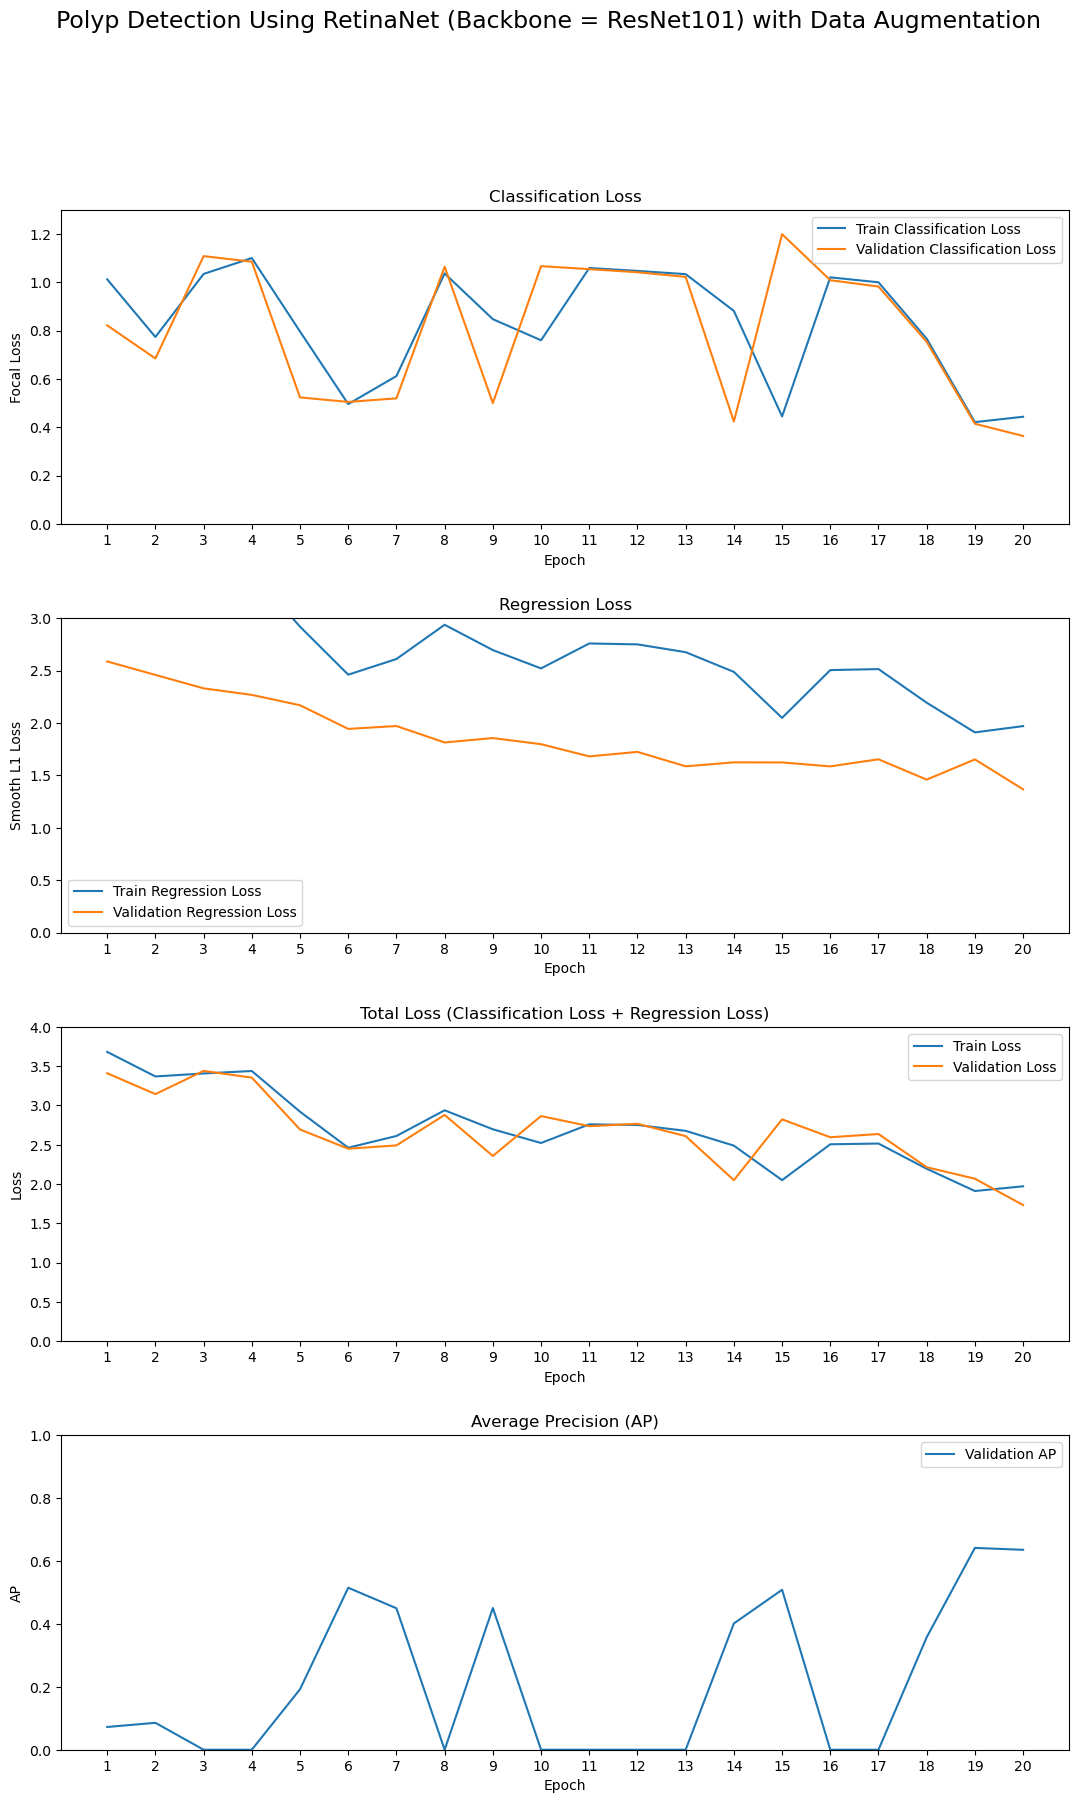

In [18]:
fig =  r'C:\Users\Asus\Desktop\retinanet_resnet101_aug.png'
plot_history(history_aug, fig, 'Polyp Detection Using RetinaNet (Backbone = ResNet101) with Data Augmentation', epochs)